# Purpose

All my stuff

# Functions

In [ ]:
def get_channel_df(channel):
    ''' Purpose: create the dataframe for a channel
        Input: string channel
        output: dataframe df'''

    #---Get and clean channel
    data = channels_df.loc[channel]['data'] #Get channel data
    data = data[(data >=0) & (data < 24000)] #Clean edges

    # Make single data at boundaries so that bins are always same
    data = np.append(data, [0, 24000])

    
    #---create channel data frame with bins and bin_counts
    counts, bin_edges = np.histogram(data, bins = 6000) #create histogram
    bin_edges = bin_edges[:-1] #drop last bin edge so len(heights) == len(bin_edges)

    #---normalize data
    counts = counts / len(data)

    #create df
    df = pd.DataFrame({
        'Bin_Left_Edge': bin_edges,
        'Count': counts}) 

    return df

In [ ]:
def get_channel_peaks(channel):
    '''---Takes in string channel id, returns peak_locations and peak heights as np.arrays---'''


    #---create channel data frame with bins and bin_counts
    df = get_channel_df(channel)
    bin_edges = df['Bin_Left_Edge']
    heights = df['Count']
    
    #---Remove the baseline of data using spline
    flat_df = df.copy()
    baseline = savgol_filter(heights, 200, 3)
    flat_df['Count'] = flat_df['Count'] - baseline
    flat_hist = np.array(flat_df['Count'])


    #---Use flattened data to find peaks
    peak_locs, props = find_peaks(flat_hist, height = 0, prominence = .0010, distance = 20, width = 1)
    peak_heights = props['peak_heights']
    return peak_locs, peak_heights
    

In [ ]:
def plot_channel(channel):
    df = get_channel_df(channel)
    ax = df.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = True, color = 'orange', xlim = (0, 20000))
    bin_edges = df['Bin_Left_Edge']
    heights = df['Count']
    peaks, peak_heights = get_channel_peaks(channel) 
    ax.scatter(bin_edges[peaks], heights[peaks], color = 'r', marker = 'o')
    plt.title('og data with peaks')


In [ ]:
def make_spline(channel):
    '''---Purpose: Create a spline line for baseline removal
    ------Input: Takes in the channel data as np.array, and bins as np.array
    ------Output: Returns the spline line as np.array---'''
    #---Get and clean channel
    data = channels_df.loc[channel]['data'] #Get channel data
    data = data[(data >=0) & (data < 24000)] #Clean edges
    

    #---Create low-binned dataframe for spline   
    counts_low, bin_edges_low = np.histogram(data, bins = 50) #create low-binned histogram
    bin_edges_low = bin_edges_low[:-1]  #drop last bin
    counts_low = counts_low / 100 #adjust for difference in binning

    #---Create Spline to fit low-binned dataframe
    spl = make_interp_spline(bin_edges_low, counts_low, k=3) #create spline object
    x = np.linspace(0, 24000, 6000)
    spline = spl(x) #make spline line
    spline = np.maximum(spline, 0)

    return spline

# Read in data

In [14]:
#imports
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import  make_interp_spline
from scipy.signal import savgol_filter

In [3]:
#
filepath = r"..\hdf5_data\210601_NBS295-106\20210601_152616_mass-001.hdf5"

chan_dict = []
with h5py.File(filepath, 'r') as hdf_file:
    print(list(hdf_file['chan1'].keys()))
    for i, channel in enumerate(list(hdf_file.keys())):
        chan_num = channel
        chan_data = np.array(hdf_file[channel]['filt_value'])

        chan_dict.append({'channel' : chan_num, 'data' : chan_data})


channels_df = pd.DataFrame(chan_dict)
channels_df = channels_df.set_index('channel')
channels_df

['average_pulse', 'calibration', 'cuts', 'energy', 'filt_phase', 'filt_phase_corr', 'filt_value', 'filt_value_dc', 'filt_value_matched', 'filt_value_phc', 'filt_value_tdc', 'filters', 'matchX', 'matchY', 'match_goodMatches', 'match_peaks', 'min_value', 'noise_autocorr', 'noise_psd', 'peak_index', 'peak_value', 'postpeak_deriv', 'pretrig_deriv', 'pretrig_mean', 'pretrig_offset', 'pretrig_rms', 'promptness', 'ptdc_anchors', 'ptdc_baselines', 'pulse_average', 'pulse_rms', 'rise_time', 'rowcount', 'shift1', 'tdc_anchors', 'tdc_baselines', 'timestamp']


,data
channel,
chan1,"[1917.8376, 2934.2834, 1235.1354, 8561.532, 22..."
chan101,"[9945.653, 11679.518, 8148.7476, 8897.93, 1198..."
chan103,"[11883.796, 10292.644, 4876.378, 7284.5176, 14..."
chan105,"[16857.314, 13127.779, 7157.272, 8648.918, 109..."
chan107,"[8264.235, 12281.665, 9715.321, 4386.601, 9545..."
...,...
chan91,"[8327.866, 10658.192, 9713.913, 11110.397, 111..."
chan93,"[9339.398, 5042.0146, 13543.274, 771.2593, 898..."
chan95,"[1961.5458, 10050.026, 5540.5645, 8491.4, 1023..."


# Baseline Removal

## Low-binned spline

In [4]:
# Get data from channel
x_01 = channels_df.loc['chan1']['data']
x_01 = x_01[(x_01 >=0) & (x_01 < 24000)] #Negative energy cannot be measured. There is no meaninful data above 24000 in any file.

<Axes: xlabel='Bin_Left_Edge'>

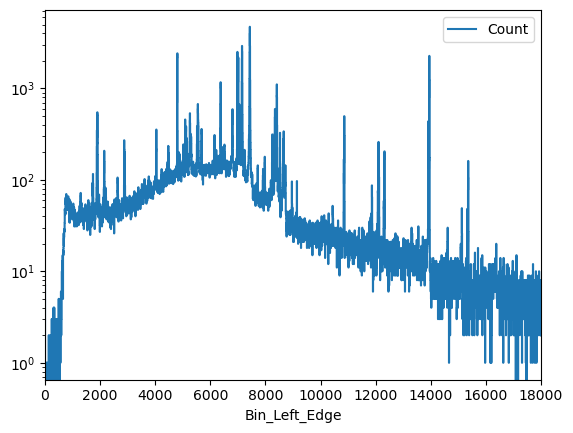

In [6]:
hist_01, bin_edges_01 = np.histogram(x_01, bins = 5000)

bin_edges_01 = bin_edges_01[:-1]  
df01 = pd.DataFrame({
    'Bin_Left_Edge': bin_edges_01,
    'Count': hist_01})

df01

df01.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = True, xlim = (0, 18000))

<Axes: xlabel='Bin_Left_Edge'>

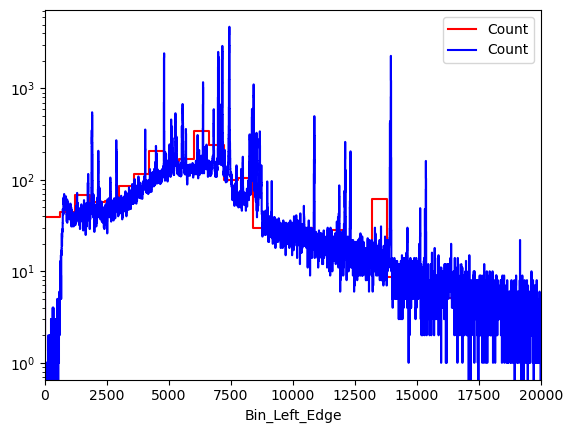

In [7]:
#create low-binned df for spline
hist_01_low, bin_edges_01_low = np.histogram(x_01, bins = 40)
e_01_low = bin_edges_01_low[:-1]  
df01_low = pd.DataFrame({
    'Bin_Left_Edge': e_01_low,
    'Count': hist_01_low})

df01_low['Count'] = df01_low['Count'] / 125
ax = df01_low.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = True, xlim = (0, 20000), color = 'red')
df01.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = True, xlim = (0, 20000), color = 'blue', ax = ax)

<class 'numpy.ndarray'> [2.54083455e-01 5.05383634e+00 9.85358922e+00 ... 2.39846192e+04
 2.39894190e+04 2.39942188e+04]
<class 'numpy.ndarray'> [1.368      2.04136048 2.70694343 ... 3.02192059 3.03443654 3.04706683]
True


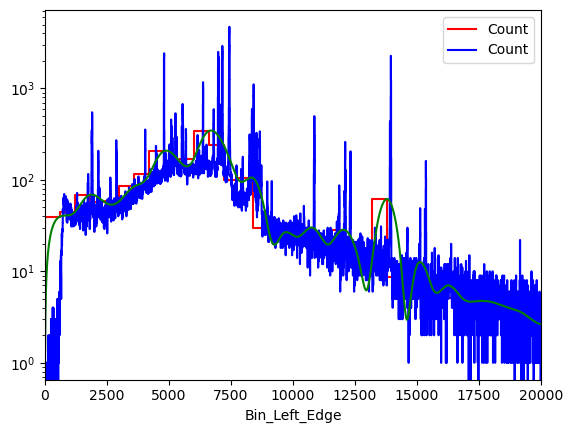

In [12]:
#make spline
spl = make_interp_spline(df01_low['Bin_Left_Edge'], df01_low['Count'], k=3)
x = np.linspace(min(df01['Bin_Left_Edge']), max(df01['Bin_Left_Edge']), len(df01['Bin_Left_Edge']))
print(type(x), x)
y = spl(x)
print(type(y), y)
print(len(y) == len(df01['Bin_Left_Edge']))
ax = df01_low.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = True, xlim = (0, 20000), color = 'red')
df01.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y = 'Count', logy = True, xlim = (0, 20000), color = 'blue', ax = ax)
ax.plot(x, y, color = 'green')
plt.yscale('log')

In [15]:
flat_df01 = df01.copy()
flat_df01['Count'] = flat_df01['Count'] - y
flat_hist = np.array(flat_df01['Count'])
print(type(flat_hist))

<class 'numpy.ndarray'>


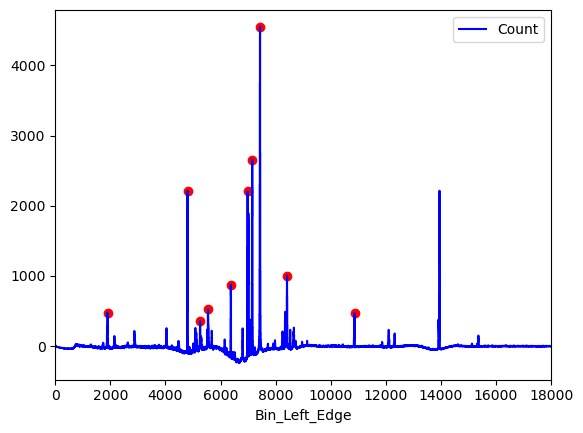

In [16]:
peaks, props = find_peaks(flat_hist, height = 300, prominence = 300, distance = 20, width = 2)
ax = flat_df01.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y = 'Count', logy = False, xlim = (0000, 18000), color = 'blue')
ax.scatter(bin_edges_01[peaks], flat_hist[peaks], color = 'r', marker = 'o')

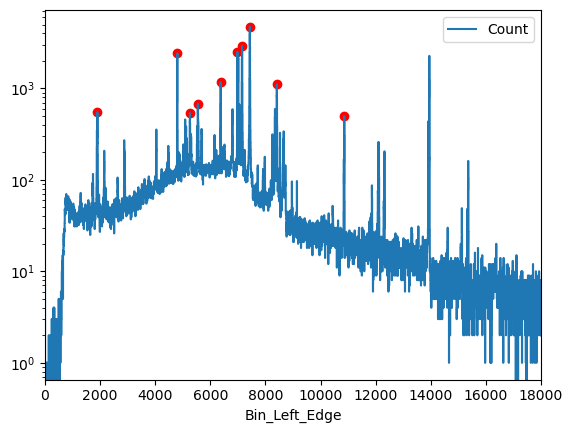

In [17]:
ax = df01.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = True, xlim = (0, 18000))
ax.scatter(bin_edges_01[peaks], hist_01[peaks], color = 'r', marker = 'o')

## Savgol_filter

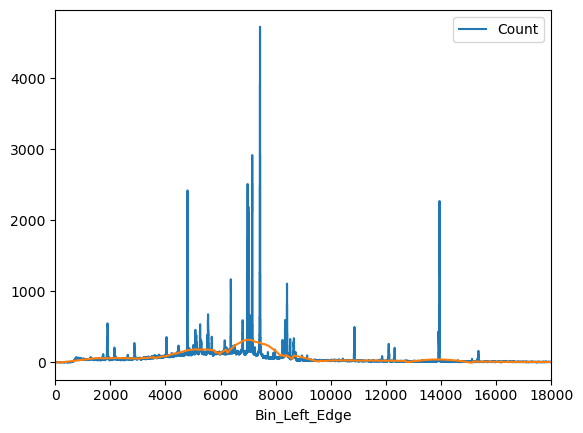

In [24]:
flat_df = df01.copy()
heights = flat_df['Count']
baseline = savgol_filter(heights, 500, 3)
ax = df01.plot(drawstyle = 'steps-pre', x = 'Bin_Left_Edge', y =  'Count', logy = False, xlim = (0, 18000))
ax.plot(flat_df['Bin_Left_Edge'], baseline, label='baseline')

In [25]:
flat_df['Count'] = flat_df['Count'] - baseline
flat_hist = np.array(flat_df['Count'])

In [26]:
#---Use flattened data to find peaks
peak_locs, props = find_peaks(flat_hist, height = 0, prominence = .0010, distance = 20, width = 1)
peak_heights = props['peak_heights']

# Peak finding

## Derivatives

# Align Peaks

# Sum Spectra